# Quickstart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bdms

In [2]:
d = 2
birth_process = bdms.poisson.DiscreteProcess([1.0, 2.0])
death_process = bdms.poisson.ConstantProcess(1.0)
mutation_process = bdms.poisson.ConstantProcess(1.0)
mutator = bdms.mutators.DiscreteMutator(range(d), np.array([[0, 1], [1, 0]]))

In [3]:
rng = np.random.default_rng(seed=0)

In [4]:
tree = bdms.Tree()
tree.state = 0

time_to_sampling = 10.0

tree.evolve(
    time_to_sampling,
    birth_process=birth_process,
    death_process=death_process,
    mutation_process=mutation_process,
    mutator=mutator,
    min_survivors=100,
    seed=rng,
)

TypeError: setWidth(self, int): argument 1 has unexpected type 'float'

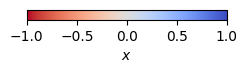

In [7]:
tree.render("state", "%%inline")

## Inhomogeneous processes

### Phenotype-modulated model

#### Parameters

##### Response functions

For the birth rate we'll include an external field $f(t)$ and interaction $\phi(x, f(t))$ for temporally modulating the phenotype response

In [2]:
def f(t):
    return 1 / (1 + np.exp(-1 * t)) - 1 / 2


def φ(x, f):
    return x - f

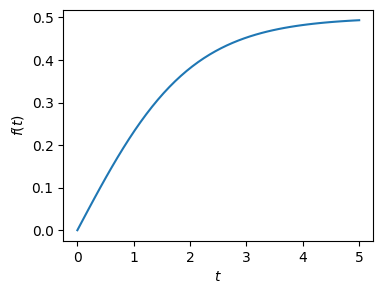

In [3]:
t = np.linspace(0, 5)
plt.figure(figsize=(4, 3))
plt.plot(t, f(t), label="f(t)")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.show()

In [4]:
birth_rate = bdms.poisson.ModulatedPhenotypeResponse(
    bdms.poisson.SigmoidResponse(xscale=2.0, xshift=0, yscale=3, yshift=1e-3), f, φ
)
death_rate = bdms.poisson.ConstantResponse(0.1)
mutation_rate = bdms.poisson.ConstantResponse(1.0)

##### Mutator

In [5]:
mutator = bdms.mutators.GaussianMutator(shift=-0.1, scale=0.1)

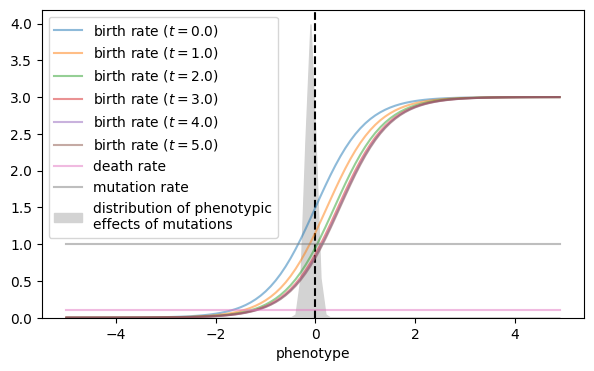

In [6]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(7, 4))
plt.axvline(0, color="k", linestyle="--")
for t in np.linspace(0, 5, 6):
    plt.plot(
        x_grid,
        birth_rate.λ_phenotype_time(x_grid, t),
        label=f"birth rate ($t={t}$)",
        alpha=0.5,
    )
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(
    x_grid,
    mutator.prob(0, x_grid),
    color="lightgrey",
    label="distribution of phenotypic\neffects of mutations",
)
plt.xlabel("phenotype")
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

#### Simulate

In [8]:
time_to_sampling = 5
for iter in range(1000):
    try:
        tree = bdms.Tree()
        tree.x = 0
        tree.evolve(
            time_to_sampling,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            birth_mutations=False,
            seed=rng,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.tree.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

try 1 failed, 'number of survivors 0 is less than min_survivors=100'
try 2 failed, 'number of survivors 33 is less than min_survivors=100'
try 3 failed, 'number of survivors 52 is less than min_survivors=100'
try 4 failed, 'number of survivors 3 is less than min_survivors=100'
try 5 failed, 'number of survivors 14 is less than min_survivors=100'
try 6 failed, 'number of survivors 3 is less than min_survivors=100'
try 7 failed, 'number of survivors 17 is less than min_survivors=100'
try 8 failed, 'number of survivors 12 is less than min_survivors=100'
try 9 failed, 'number of survivors 8 is less than min_survivors=100'
try 10 failed, 'number of survivors 5 is less than min_survivors=100'
try 11 failed, 'number of survivors 3 is less than min_survivors=100'
try 12 failed, 'number of survivors 18 is less than min_survivors=100'
try 13 failed, 'number of survivors 7 is less than min_survivors=100'
try 14 failed, 'number of survivors 60 is less than min_survivors=100'
try 15 succeeded, tip 

In [9]:
tree.sample_survivors(n=20, seed=rng)
tree.prune()

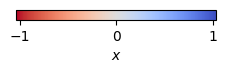

In [10]:
# NBVAL_SKIP

tree.render("x", "%%inline")

### Rate-modulated model

#### Parameters

##### Response functions

We'll modulate the birth rate to approximate a capacity constraint

In [11]:
def f(λ, x, t):
    return λ * np.exp(-0.2 * t)

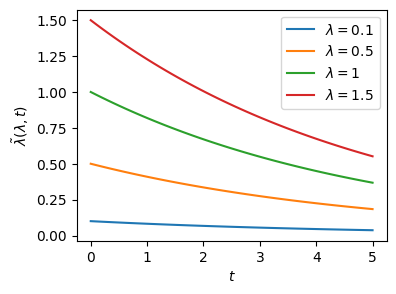

In [12]:
t = np.linspace(0, 5)
plt.figure(figsize=(4, 3))
for λ in [0.1, 0.5, 1, 1.5]:
    plt.plot(t, f(λ, None, t), label=f"$\lambda={λ}$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde\lambda(\lambda, t)$")
plt.legend()
plt.show()

In [13]:
birth_rate = bdms.poisson.ModulatedRateResponse(
    bdms.poisson.SigmoidResponse(xscale=2.0, xshift=0, yscale=3, yshift=0.0), f
)

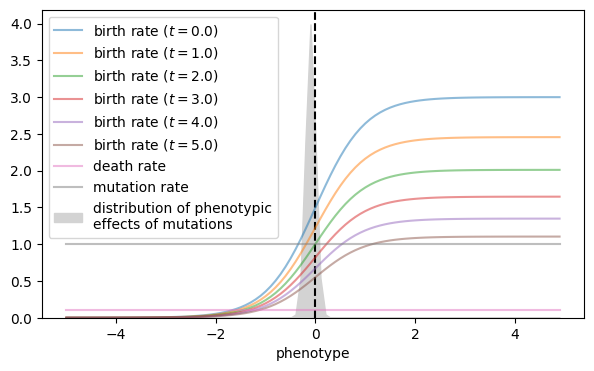

In [14]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(7, 4))
plt.axvline(0, color="k", linestyle="--")
for t in np.linspace(0, 5, 6):
    plt.plot(
        x_grid,
        birth_rate.λ_phenotype_time(x_grid, t),
        label=f"birth rate ($t={t}$)",
        alpha=0.5,
    )
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(
    x_grid,
    mutator.prob(0, x_grid),
    color="lightgrey",
    label="distribution of phenotypic\neffects of mutations",
)
plt.xlabel("phenotype")
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

#### Simulate

In [15]:
time_to_sampling = 5
for iter in range(1000):
    try:
        tree = bdms.Tree()
        tree.x = 0
        tree.evolve(
            time_to_sampling,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            capacity=1000,
            birth_mutations=False,
            seed=rng,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.tree.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

try 1 failed, 'number of survivors 9 is less than min_survivors=100'
try 2 failed, 'number of survivors 12 is less than min_survivors=100'
try 3 failed, 'number of survivors 1 is less than min_survivors=100'
try 4 succeeded, tip count: 157


In [16]:
tree.sample_survivors(n=20, seed=rng)
tree.prune()

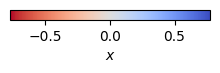

In [17]:
# NBVAL_SKIP

tree.render("x", "%%inline")